In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import xgboost
from xgboost import XGBClassifier
import joblib
import seaborn as sns 

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables

print ('Success')


Welcome to JupyROOT 6.24/06
Success


## Reading in files

In [2]:
#feature_names = ['shrclusdir2', 'trk_chipr_best', 'trk_energy_hits_tot', 'shr_phi_v', 'trk_dir_y_v', 'NeutrinoEnergy2', 'trk_dir_z_v']
feature_names = Variables.First_pass_vars
feature_names_MC = Variables.First_pass_vars + ["weight"]

HNL_masses = Constants.HNL_mass_samples #in MeV

Run = "run1" #Either "run1" or "run3" at the moment

loc_pkls = f"pkl_files/{Run}/current_files/"

print(f"Loading {Run} .pkls" + "\n")

Presel_overlay = pd.read_pickle(loc_pkls+f"Preselected_overlay_{Run}_my_vars_flattened.pkl")
Presel_dirt = pd.read_pickle(loc_pkls+f"Preselected_dirt_{Run}_my_vars_flattened.pkl")
Presel_EXT = pd.read_pickle(loc_pkls+f"Preselected_EXT_{Run}_my_vars_flattened.pkl")

signal_samples_dict = {}

for HNL_mass in HNL_masses:
    Presel_signal = pd.read_pickle(loc_pkls+f"Preselected_signal_{HNL_mass}MeV_{Run}_my_vars_flattened.pkl")
    signal_samples_dict[HNL_mass] = Presel_signal

print("Overlay .pkl is "+str(len(Presel_overlay))+" entries long.")
print("Dirt .pkl is "+str(len(Presel_dirt))+" entries long.")
print("EXT .pkl is "+str(len(Presel_EXT))+" entries long.")
for HNL_mass in HNL_masses:
    print(f"{HNL_mass} Signal .pkl is "+str(len(signal_samples_dict[HNL_mass]))+" entries long.")

print()
print("Variables in overlay is " + str(len(Presel_overlay.keys())))
print("Variables in dirt is " + str(len(Presel_dirt.keys())))
print("Variables in EXT is " + str(len(Presel_EXT.keys())))
for HNL_mass in HNL_masses:
    print(f"Variables in {HNL_mass}MeV Signal is " + str(len(signal_samples_dict[HNL_mass].keys())))


Loading run1 .pkls

Overlay .pkl is 90444 entries long.
Dirt .pkl is 12402 entries long.
EXT .pkl is 12349 entries long.
20 Signal .pkl is 31903 entries long.
50 Signal .pkl is 31976 entries long.
100 Signal .pkl is 30575 entries long.
150 Signal .pkl is 32271 entries long.
180 Signal .pkl is 28436 entries long.
200 Signal .pkl is 28907 entries long.

Variables in overlay is 122
Variables in dirt is 122
Variables in EXT is 118
Variables in 20MeV Signal is 118
Variables in 50MeV Signal is 118
Variables in 100MeV Signal is 118
Variables in 150MeV Signal is 118
Variables in 180MeV Signal is 118
Variables in 200MeV Signal is 118


# Preparing dataframes for xgboost

In [3]:
def Prepare_dfs_for_xgb(df, variable_list, edited_vars): #The default value for missing data in XGB is 0. So this changes those very large negative values to -9999.
    value = -1e15
    new_value = -9999
    for variable in df.keys():
        if(len(df.loc[df[variable] < value]) > 0):
            edited_vars.append(variable)
            df.loc[(df[variable] < value), variable] = new_value #Sets the new value
        if(len(df.loc[df[variable] == -1.0]) > 0):
            edited_vars.append(variable)
            df.loc[(df[variable] == -1.0), variable] = new_value #Sets the new value
        if(len(df.loc[df[variable] == np.nan]) > 0):
            edited_vars.append(variable)
            df.loc[(df[variable] == np.nan), variable] = new_value #Sets the new value
        if(len(df.loc[df[variable] == np.inf]) > 0):
            edited_vars.append(variable)
            df.loc[(df[variable] == np.inf), variable] = new_value #Sets the new value
            
    df_edited = df[variable_list].copy() #Ensures the variable list is just those given, i.e removing any others
    # print("Variables in Overlay is " + str(len(df_edited.keys())))
    # print("Variables in Signal is " + str(len(df_edited.keys())))
    # df_edited = df.copy()
    return df_edited

def only_keep_highest_E(df):
    df["highest_E"]=df['pfnplanehits_Y'].groupby("entry").transform(max) == df['pfnplanehits_Y']
    df_new = df.query("highest_E").copy()
    return df_new
    
#For unflattened
# def check_type(df, variable_list, edited_vars):
#     value = -1e15
#     new_value = -9999
#     for variable in df.keys():
#         #print(variable)
#         if(type(df[variable][0]==np.ndarray)):
#             for i in df[variable]:
                
#         else:
#             if(len(df.loc[df[variable] < value]) > 0):
#                 print(variable)
#                 edited_vars.append(variable)
#                 print(type(df.loc[(df[variable] < value), variable])) #Sets the new value
#         if(len(df.loc[df[variable] == -1.0]) > 0):
#             print(variable)
#             edited_vars.append(variable)
#             print(type(df.loc[(df[variable] == -1.0), variable])) #Sets the new value
#     df_edited = df[variable_list].copy() #Ensures the variable list is just those given, i.e removing any others
#     # print("Variables in Overlay is " + str(len(df_edited.keys())))
#     # print("Variables in Signal is " + str(len(df_edited.keys())))
#     # df_edited = df.copy()
#     return df_edited

#print(len(Presel_overlay.loc[Presel_overlay[variable] < value])/len(Presel_overlay[variable]))

In [4]:
edited_vars_overlay, edited_vars_dirt, edited_vars_EXT, edited_vars_signal = [], [], [], []

# Cleaned_Presel_overlay = check_type(Presel_overlay, feature_names, edited_vars_overlay)
# Cleaned_Presel_dirt = check_type(Presel_dirt, feature_names, edited_vars_dirt)
# Cleaned_Presel_EXT = check_type(Presel_EXT, feature_names, edited_vars_EXT)
# Cleaned_Presel_signal = check_type(Presel_signal, feature_names, edited_vars_signal)

Cleaned_Presel_overlay = Prepare_dfs_for_xgb(Presel_overlay, feature_names_MC, edited_vars_overlay)
Cleaned_Presel_dirt = Prepare_dfs_for_xgb(Presel_dirt, feature_names_MC, edited_vars_dirt)
Cleaned_Presel_EXT = Prepare_dfs_for_xgb(Presel_EXT, feature_names, edited_vars_EXT)

Cleaned_Presel_overlay_highest_E = only_keep_highest_E(Cleaned_Presel_overlay)
Cleaned_Presel_dirt_highest_E = only_keep_highest_E(Cleaned_Presel_dirt)
Cleaned_Presel_EXT_highest_E = only_keep_highest_E(Cleaned_Presel_EXT)

cleaned_signal_dict = {}
cleaned_signal_dict_highest_E = {}
for HNL_mass in HNL_masses:
    Cleaned_Presel_signal = Prepare_dfs_for_xgb(signal_samples_dict[HNL_mass], feature_names, edited_vars_signal)
    cleaned_signal_dict[HNL_mass] = Cleaned_Presel_signal
    cleaned_signal_dict_highest_E[HNL_mass] = only_keep_highest_E(Cleaned_Presel_signal)
    

print("Variables in overlay is " + str(len(Cleaned_Presel_overlay_highest_E.keys())))
print("Variables in dirt is " + str(len(Cleaned_Presel_dirt_highest_E.keys())))
print("Variables in EXT is " + str(len(Cleaned_Presel_EXT_highest_E.keys())))
for HNL_mass in HNL_masses:
    print(f"Variables in {HNL_mass}MeV Signal is " + str(len(cleaned_signal_dict_highest_E[HNL_mass].keys())))

# overlay_variables_test = Cleaned_Presel_overlay.keys().to_numpy()
# u, c = np.unique(overlay_variables_test, return_counts=True)
# dup = u[c > 1]
# print(dup)

Variables in overlay is 120
Variables in dirt is 120
Variables in EXT is 119
Variables in 20MeV Signal is 119
Variables in 50MeV Signal is 119
Variables in 100MeV Signal is 119
Variables in 150MeV Signal is 119
Variables in 180MeV Signal is 119
Variables in 200MeV Signal is 119


## Splitting samples into test and training

In [5]:
#I should probably create new dataframes here for just the test events. Then the "results" can be saved as a branch, as it will be the same size

#feature_names = ['shrclusdir2', 'trk_chipr_best', 'trk_energy_hits_tot', 'shr_phi_v', 'trk_dir_y_v', 'NeutrinoEnergy2', 'trk_dir_z_v']
bdt_vars = Variables.First_pass_vars_for_BDT

new_value = -9999 #This tells XGB what number refers to missing data for all variables

signal_train_dict = {}
signal_test_dict = {}
labels_dict = {} #I should try and understand what this is doing better

train_vs_test_fraction = 0.7

data_bkg = Cleaned_Presel_overlay_highest_E

data_train_bkg = data_bkg[int(len(data_bkg)*train_vs_test_fraction):]
data_test_bkg = data_bkg[:int(len(data_bkg)*train_vs_test_fraction)]

for HNL_mass in HNL_masses:
    signal_train_dict[HNL_mass] = cleaned_signal_dict_highest_E[HNL_mass][int(len(cleaned_signal_dict_highest_E[HNL_mass])*train_vs_test_fraction):]
    signal_test_dict[HNL_mass] = cleaned_signal_dict_highest_E[HNL_mass][:int(len(cleaned_signal_dict_highest_E[HNL_mass])*train_vs_test_fraction)]
    
    labels_dict[HNL_mass] = [1]*len(signal_train_dict[HNL_mass][bdt_vars]) + [0]*len(data_train_bkg[bdt_vars])
    print(len(signal_train_dict[HNL_mass])+len(data_train_bkg))
    print(len(labels_dict[HNL_mass]))
    print()


18834
18834

18633
18633

18394
18394

18790
18790

18170
18170

18217
18217



# BDT test and training

In [6]:
#Making train and test samples
#Do I need to create new "random" training samples for each signal sample to train against? - so far have not

In [7]:
xgb_train_dict = {}
xgb_test_dict = {}

xgb_test_bkg = xgboost.DMatrix(data_test_bkg[bdt_vars], label=[0]*len(data_test_bkg[bdt_vars]), missing=new_value, feature_names=bdt_vars)

param = {'booster': 'dart',
        'max_depth':6,
        'eta':0.3,
        'objective':'binary:logistic',
#         'eval_metric':'auc', 
#        'subsample':0.5,
        'tree_method':'hist',
#         'scale_pos_weight': float(len(data_bkg_train))/float(len(data_sig_train)),
        'rate_drop': 0.1,
        'skip_drop': 0.5 }
num_round = 50
progress = dict()

for HNL_mass in HNL_masses:
    xgb_train_dict[HNL_mass] = xgboost.DMatrix(pd.concat([signal_train_dict[HNL_mass][bdt_vars], 
                                                               data_train_bkg[bdt_vars]]), 
                                               label=labels_dict[HNL_mass], 
                                                    missing=new_value, feature_names=bdt_vars)
    xgb_test_dict[HNL_mass] = xgboost.DMatrix(signal_test_dict[HNL_mass][bdt_vars], label=[1]*len(signal_test_dict[HNL_mass][bdt_vars]),
                                              missing=new_value, feature_names=bdt_vars)

    #watchlist so that you can monitor the performance of the training by iterations
    watchlist = [(xgb_train_dict[HNL_mass], 'train'), (xgb_test_dict[HNL_mass], 'test_sig'),(xgb_test_bkg,'test_bkg')]

In [8]:
print_vals = input("Do you want to retrain the BDTs? y/n ")
if print_vals == "y":
    for HNL_mass in HNL_masses:
        print(f"Training {HNL_mass} MeV BDT" + "\n")
        bdt = xgboost.train(param, xgb_train_dict[HNL_mass], num_round, watchlist,evals_result=progress, verbose_eval=False)
        # doesnt like watchlist/eval_result if using AOC
        # save model so you can load it later
        bdt.save_model(f'bdts/{Run}_{HNL_mass}_MeV_My_variables_flattened_highest_E_1.json')
    
else: 
    print("Not retraining BDTs, will load previous models in next cell")

Do you want to retrain the BDTs? y/n  n


Not retraining BDTs, will load previous models in next cell


/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Plotting 20MeV importances:
Plotting 50MeV importances:
Plotting 100MeV importances:
Plotting 150MeV importances:
Plotting 180MeV importances:
Plotting 200MeV importances:


<Figure size 864x864 with 0 Axes>

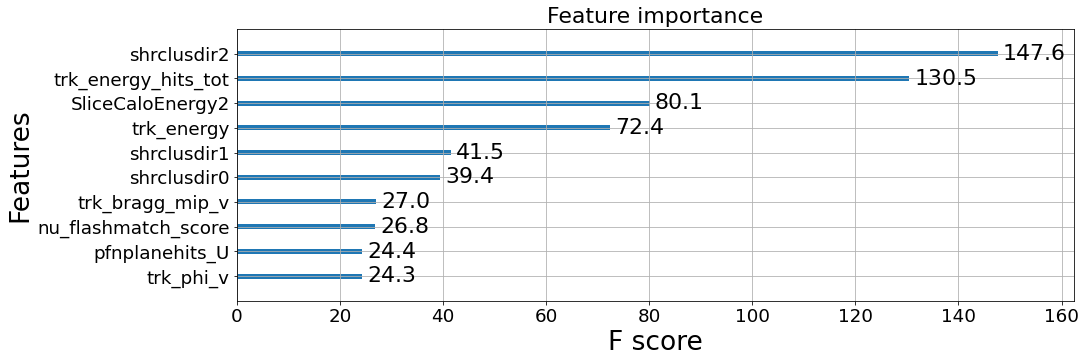

<Figure size 864x864 with 0 Axes>

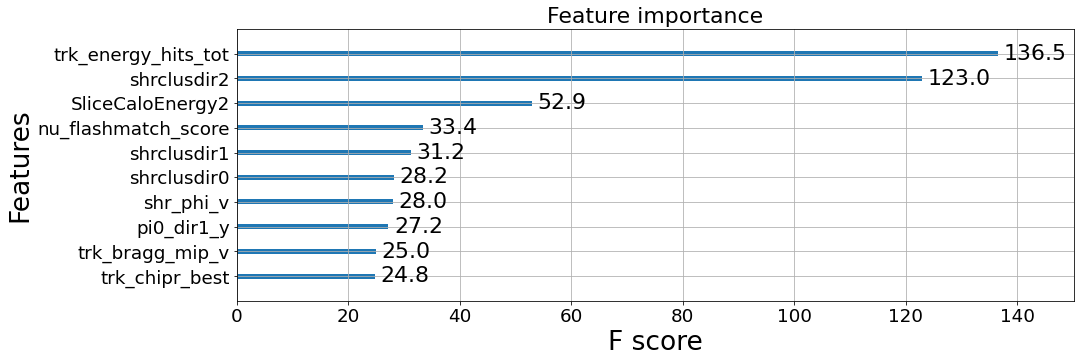

<Figure size 864x864 with 0 Axes>

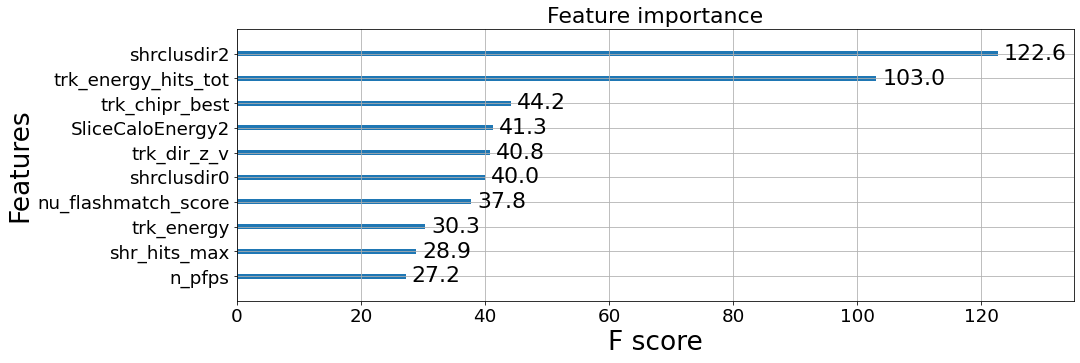

<Figure size 864x864 with 0 Axes>

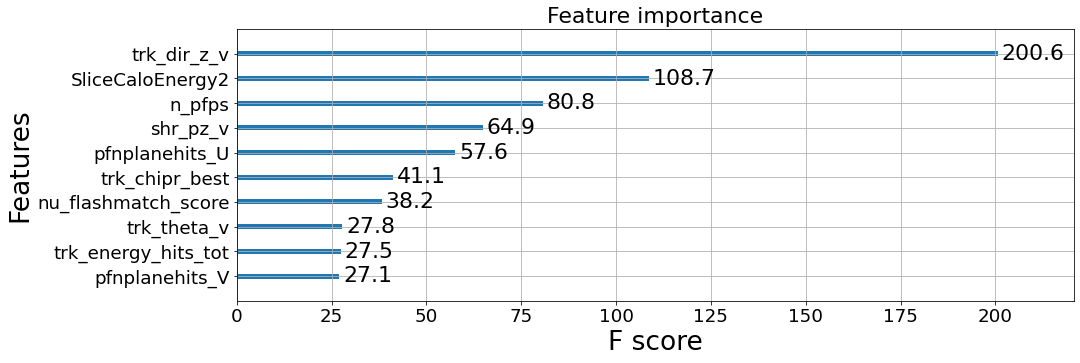

<Figure size 864x864 with 0 Axes>

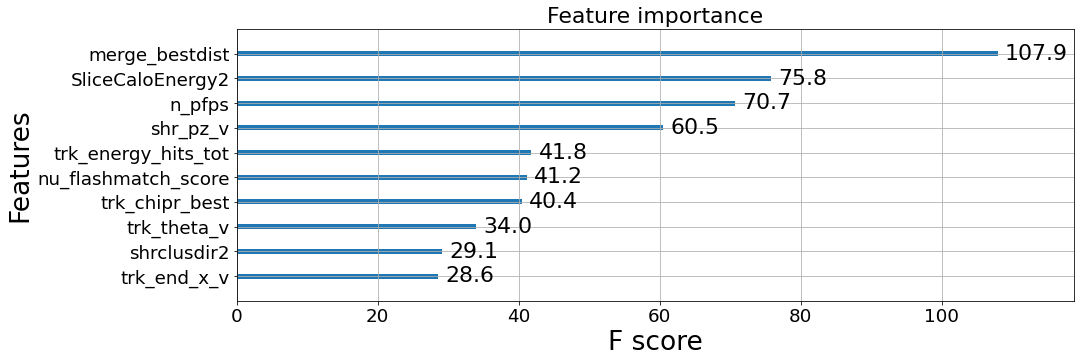

<Figure size 864x864 with 0 Axes>

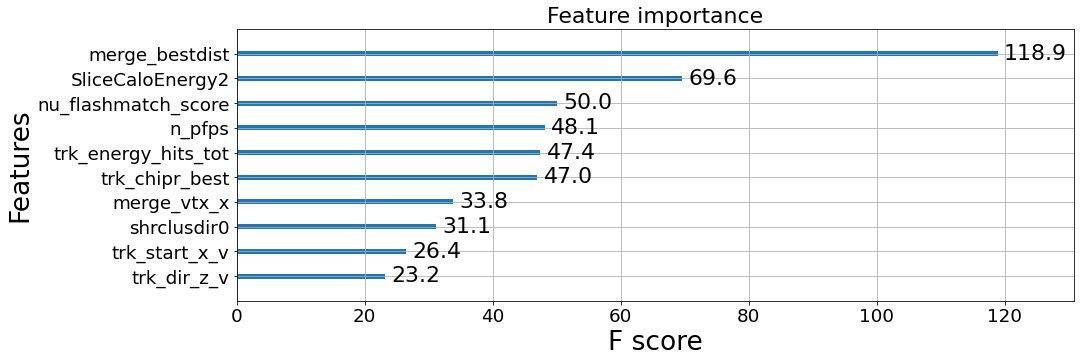

In [9]:
dirt_matrix = xgboost.DMatrix(Cleaned_Presel_dirt_highest_E[bdt_vars])
EXT_matrix = xgboost.DMatrix(Cleaned_Presel_EXT_highest_E[bdt_vars])

for HNL_mass in HNL_masses:

    bdt = xgboost.Booster()
    bdt.load_model(f'bdts/{Run}_{HNL_mass}_MeV_My_variables_flattened_highest_E_1.json')
    
    importance = bdt.get_score(importance_type="gain")
    
    for key in importance.keys():
        importance[key] = round(importance[key],1)
        
    #importance_dict[HNL_mass] = importance

    results_sig = bdt.predict(xgb_test_dict[HNL_mass])
    results_bkg = bdt.predict(xgb_test_bkg)

    results_dirt = bdt.predict(dirt_matrix)
    results_EXT = bdt.predict(EXT_matrix)
    
    Cleaned_Presel_dirt_highest_E[f'BDT_output_{HNL_mass}MeV'] = results_dirt
    Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV'] = results_EXT

    data_test_bkg[f'BDT_output_{HNL_mass}MeV'] = results_bkg
    #Can add in a second loop over HNL_masses so that I predict each signal mass point with every other mass point bdt
    signal_test_dict[HNL_mass][f'BDT_output'] = results_sig
    
    #Plotting importances of variables
    plt.figure(figsize=(12,12),facecolor='white')
    print(f"Plotting {HNL_mass}MeV importances:")
    a = xgboost.plot_importance(importance,max_num_features=10,importance_type='gain')
    

## Checking importance correlations

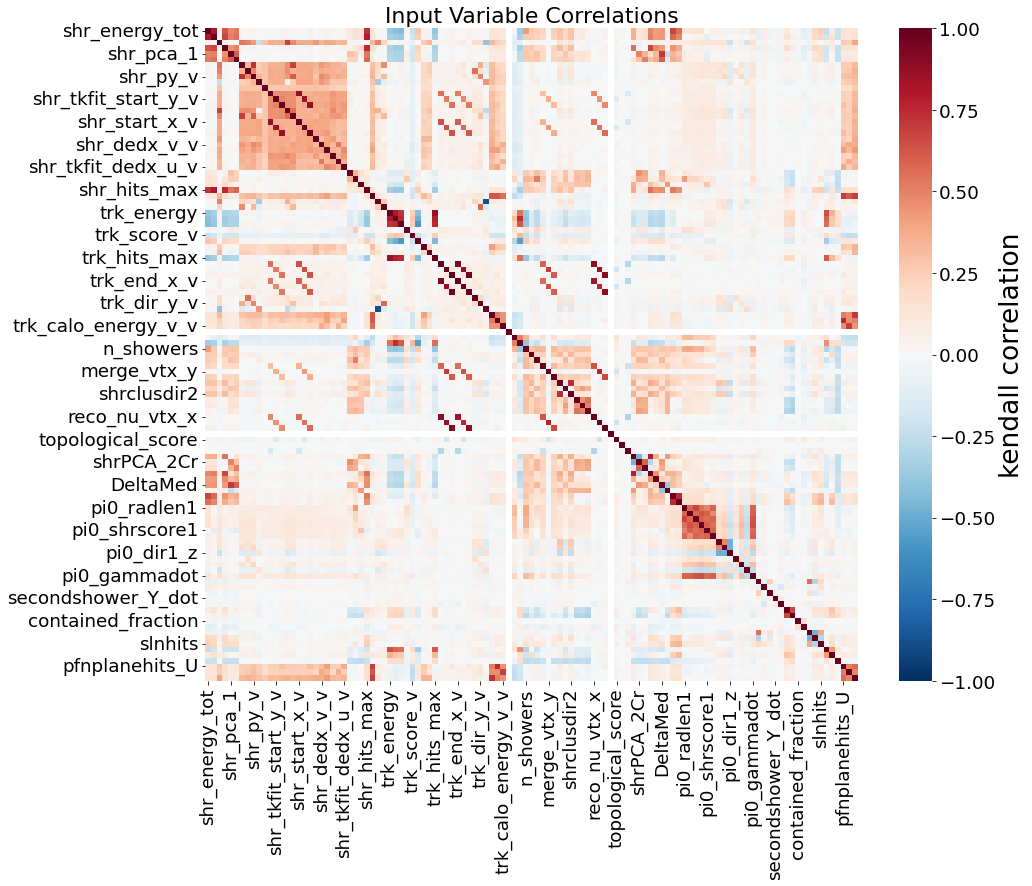

In [10]:
#Taken from Luis' code
# for HNL_mass in HNL_masses:
method = 'kendall'
correlations = cleaned_signal_dict[100][bdt_vars].astype(np.float64).corr(method=method)
plt.figure(figsize=(15,12))
sns.heatmap(correlations,vmin=-1,annot=False,square=True,cbar_kws={'label':method+' correlation'},cmap = 'RdBu_r')
plt.title('Input Variable Correlations')
plt.show()

In [10]:
#Just looking at most correlated 
# corr=cleaned_signal_dict[100][bdt_vars].corr()
# high_corr_var=np.where(corr>0.95)
# high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
# high_corr_var

## Plotting BDT Output

Scale factor for signal is 1.4286836935166993
Scale factor for overlay is 1.4285756597458756


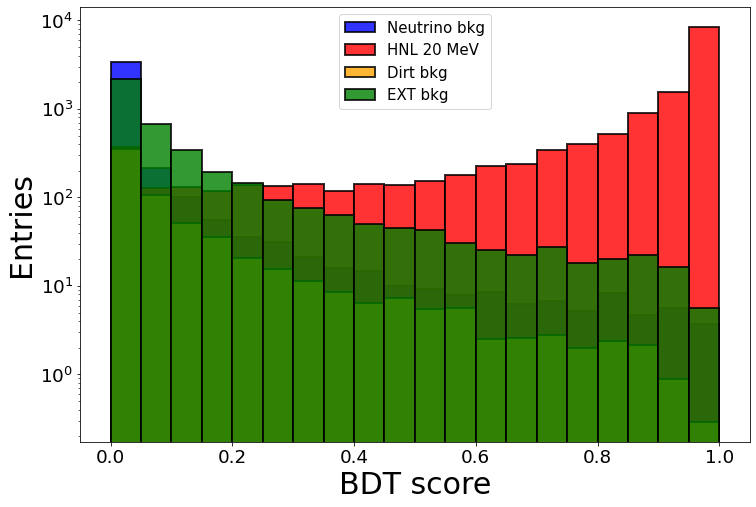

Scale factor for signal is 1.428644975288303
Scale factor for overlay is 1.4285756597458756


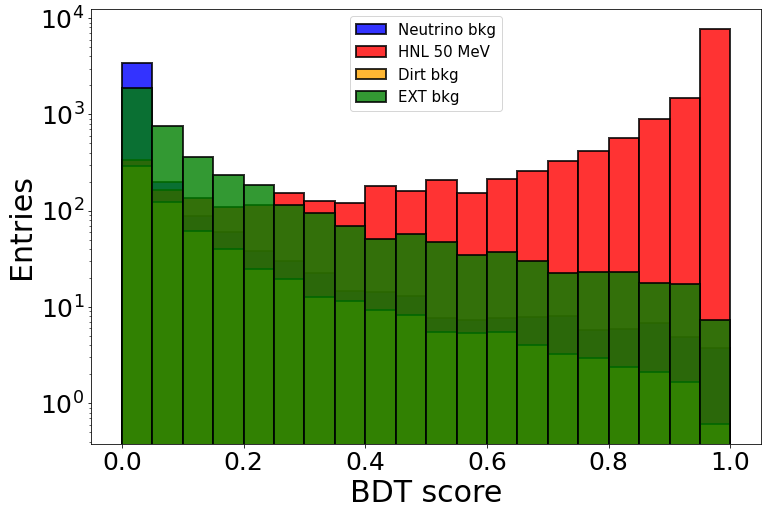

Scale factor for signal is 1.4286650644526984
Scale factor for overlay is 1.4285756597458756


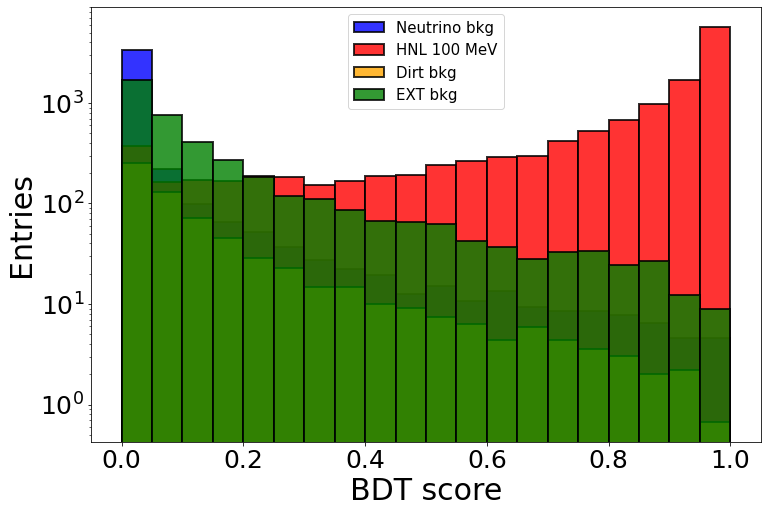

Scale factor for signal is 1.4286139497966068
Scale factor for overlay is 1.4285756597458756


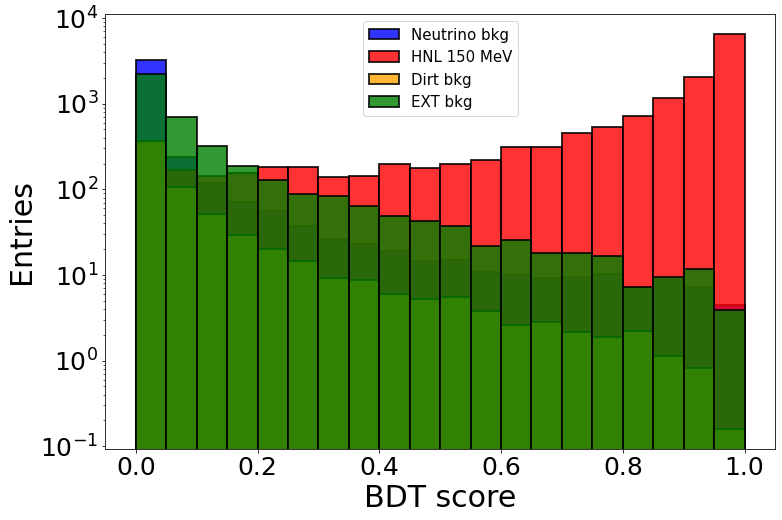

Scale factor for signal is 1.428637627432808
Scale factor for overlay is 1.4285756597458756


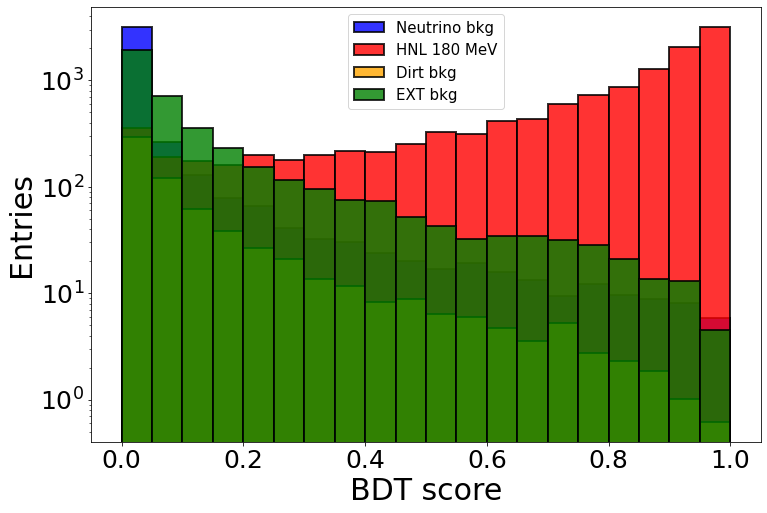

Scale factor for signal is 1.4287185354691077
Scale factor for overlay is 1.4285756597458756


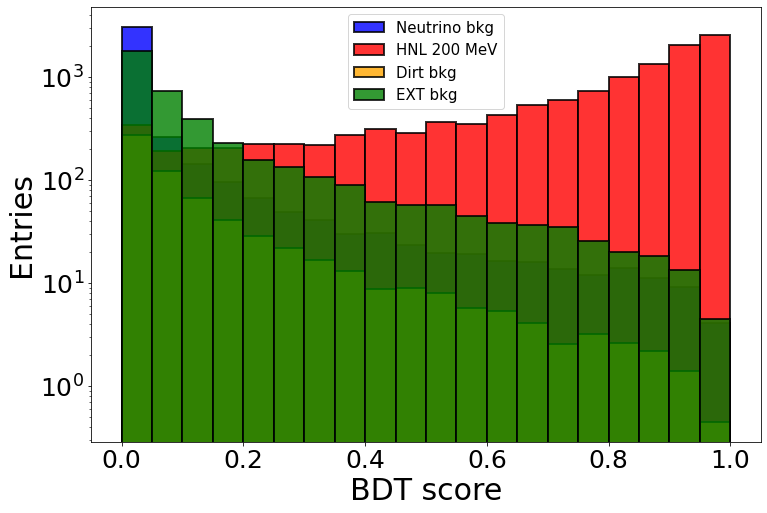

In [12]:
#Plotting BDT output after only keeping highest bdt score per event

for HNL_mass in HNL_masses:
    plt.figure(figsize=(12,8),facecolor='white')
    numdecays_signal = len(cleaned_signal_dict_highest_E[HNL_mass])
    numdecays_bkg = len(Cleaned_Presel_overlay_highest_E)
    SF_sig = numdecays_signal/len(signal_test_dict[HNL_mass][f'BDT_output'])
    SF_overlay = (numdecays_bkg)/len(data_test_bkg[f'BDT_output_{HNL_mass}MeV'])
    
    print("Scale factor for signal is " + str(SF_sig)) #Should have a dict of SF_sig and SF_overlay
    print("Scale factor for overlay is " + str(SF_overlay))
    
    if Run == "run1":
        SF_overlay_run1_corrected = Constants.SF_overlay_run1*SF_overlay #Necessary to account for the events used for training
        SF_signal_run1_corrected = SF_sig #Necessary to account for the events used for training
        EXT_scale_list = np.ones(len(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run1
        EXT_scale = Constants.SF_EXT_run1
        dirt_scale = Constants.SF_dirt_run1
        signal_scale_list = np.ones(len(signal_test_dict[HNL_mass][f'BDT_output']))*SF_signal_run1_corrected
        overlay_scale = SF_overlay_run1_corrected
        
    elif Run == "run3":
        SF_overlay_run3_corrected = Constants.SF_overlay_run3*SF_overlay #Necessary to account for the events used for training
        SF_signal_run3_corrected = SF_sig #Necessary to account for the events used for training
        EXT_scale_list = np.ones(len(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run3
        EXT_scale = Constants.SF_EXT_run3
        dirt_scale = Constants.SF_dirt_run3
        signal_scale_list = np.ones(len(signal_test_dict[HNL_mass][f'BDT_output']))*SF_signal_run3_corrected
        overlay_scale = SF_overlay_run3_corrected
    
    plt.hist(data_test_bkg[f'BDT_output_{HNL_mass}MeV'],weights=data_test_bkg["weight"]*overlay_scale,bins=20,range = [0.0,1.0], color='blue',lw=2, edgecolor="black", label='Neutrino bkg', alpha=0.8)
    plt.hist(signal_test_dict[HNL_mass][f'BDT_output'],weights=signal_scale_list,bins=20,range = [0.0,1.0], color='red',lw=2, edgecolor="black", label=f'HNL {HNL_mass} MeV', alpha=0.8)
    plt.hist(Cleaned_Presel_dirt_highest_E[f'BDT_output_{HNL_mass}MeV'],weights=Cleaned_Presel_dirt_highest_E["weight"]*dirt_scale,bins=20,range = [0.0,1.0], color='orange',lw=2, edgecolor="black", label='Dirt bkg', alpha=0.8)
    plt.hist(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV'],weights=EXT_scale_list,bins=20,range = [0.0,1.0], color='green',lw=2, edgecolor="black", label=f'EXT bkg', alpha=0.8)
    
    plt.xlabel('BDT score', fontsize=30)
    plt.ylabel('Entries', fontsize=30)
    plt.rcParams.update({'font.size': 30})
    plt.legend()
    plt.yscale("log")
    plt.show()


In [40]:
samples={'overlay_test':data_test_bkg,
         'dirtoverlay':Cleaned_Presel_dirt_highest_E,
         'beamoff':Cleaned_Presel_EXT_highest_E}

sample_norms={'overlay_test':np.array(data_test_bkg["weight"]*overlay_scale),
         'dirtoverlay':np.array(Cleaned_Presel_dirt_highest_E["weight"]*dirt_scale),
         'beamoff':EXT_scale_list}

for HNL_mass in HNL_masses:
    if Run == "run1":
        SF_signal_run1_corrected = SF_sig
        signal_scale_list = np.ones(len(signal_test_dict[HNL_mass][f'BDT_output']))*SF_signal_run1_corrected
        
    elif Run == "run3":
        SF_signal_run3_corrected = SF_sig
        signal_scale_list = np.ones(len(signal_test_dict[HNL_mass][f'BDT_output']))*SF_signal_run3_corrected
    
    sample_placeholder = {HNL_mass:signal_test_dict[HNL_mass]}
    norm_placeholder = {HNL_mass:signal_scale_list}
    samples.update(sample_placeholder)
    sample_norms.update(norm_placeholder)
    print(len(sample_norms[HNL_mass]))
    
    
#print(samples)
#print(sample_norms)

10180
9712
9154
10079
8632
8740


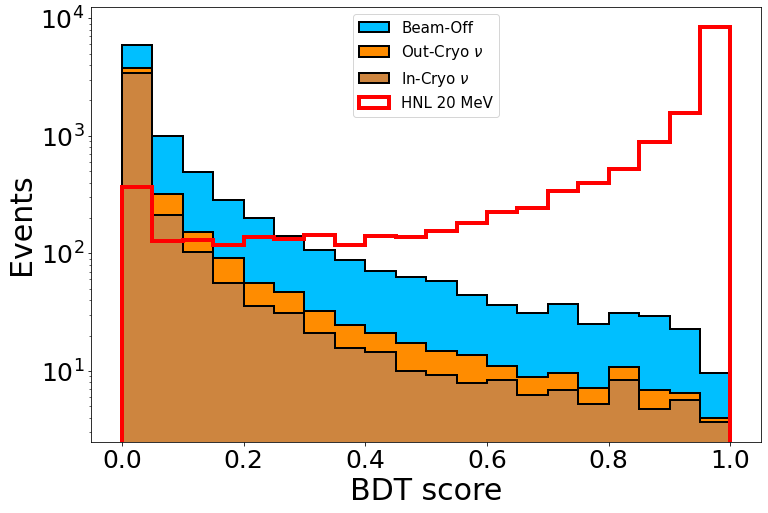

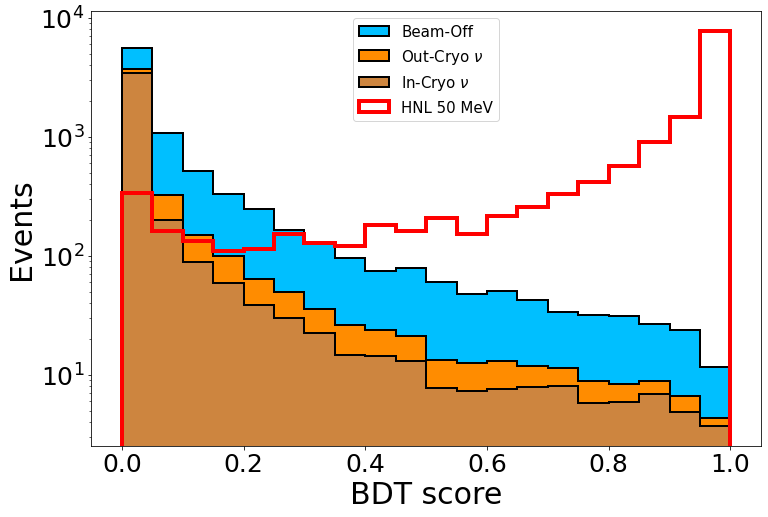

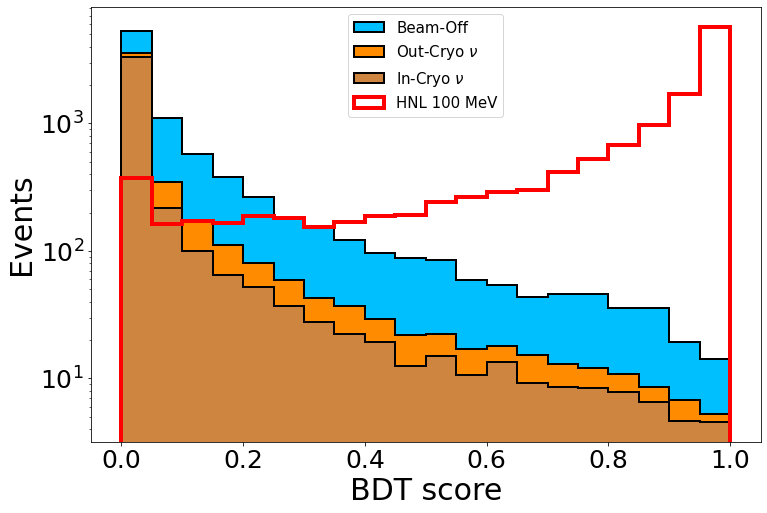

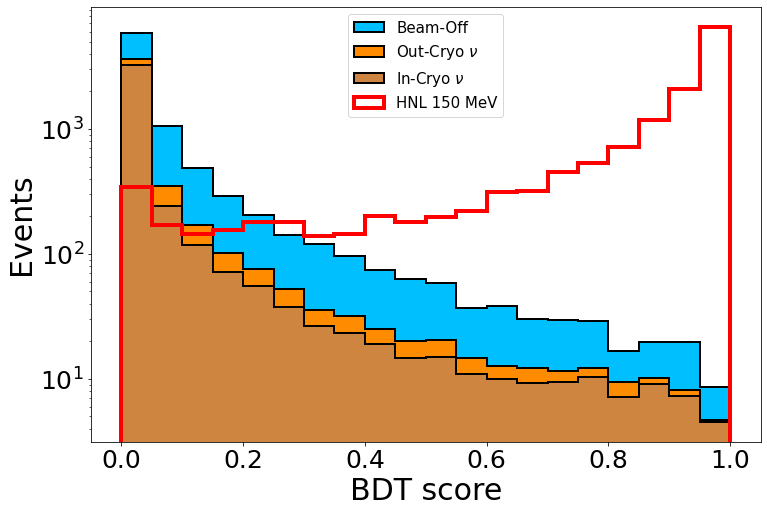

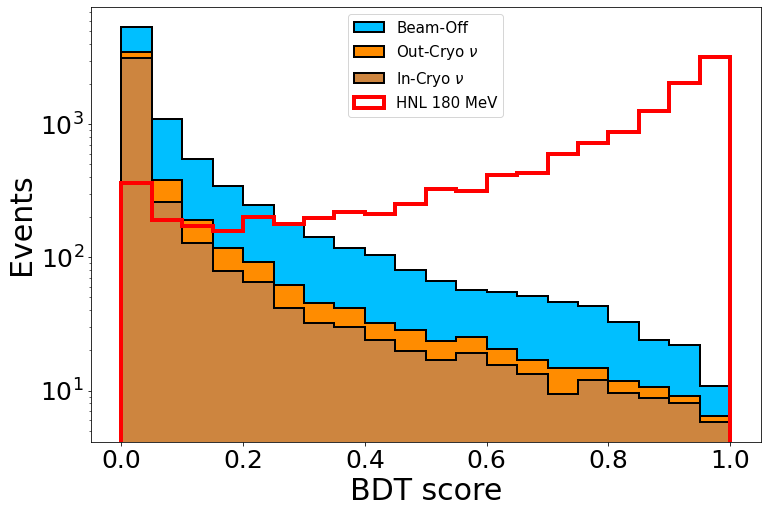

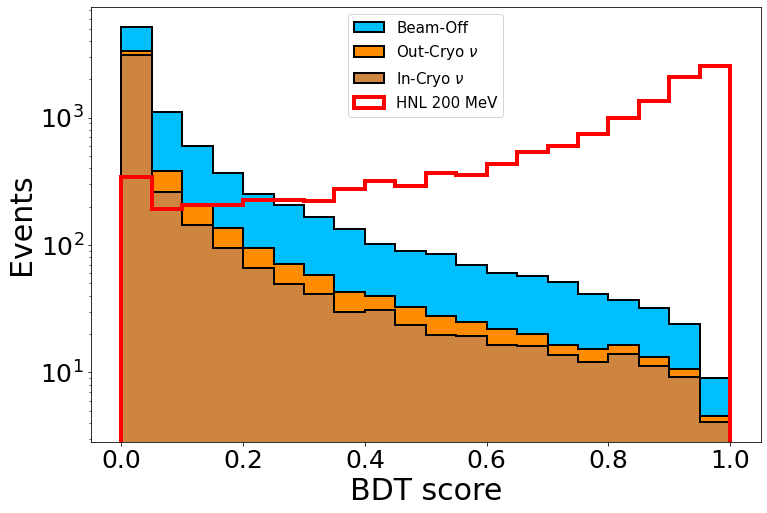

In [41]:
PT.Plot_BDT_output(HNL_masses=HNL_masses, samples=samples, sample_norms=sample_norms, colours={}, xlims=[0,1.0],
                bins=20,figsize=[12,8], MergeBins=False, density=False, legloc="upper center",logy=True)

# Function for saving histograms

In [13]:
def SaveToRoot(nbins,xlims,bkg_overlay,bkg_dirt,bkg_EXT,sig,data,fileName='test.root'):
    nBins = nbins
    binLimits = xlims
  ### Save files 
    rFile = ROOT.TFile(f'bdt_output/{fileName}','RECREATE')
    tData1 = ROOT.TH1F("Signal","Signal",nBins,binLimits[0],binLimits[1])
    for i in range(nBins):
        tData1.SetBinContent(i+1,sig['hist'][i])
        tData1.SetBinError(i+1,sig['err'][i])
    tData2 = ROOT.TH1F("bkg_overlay","bkg_overlay",nBins,binLimits[0],binLimits[1])
    for i in range(nBins):
        tData2.SetBinContent(i+1,bkg_overlay['hist'][i])
        tData2.SetBinError(i+1,bkg_overlay['err'][i])
    tData3 = ROOT.TH1F("bkg_dirt","bkg_dirt",nBins,binLimits[0],binLimits[1])
    for i in range(nBins):
        tData3.SetBinContent(i+1,bkg_dirt['hist'][i])
        tData3.SetBinError(i+1,bkg_dirt['err'][i])
    tData4 = ROOT.TH1F("bkg_EXT","bkg_EXT",nBins,binLimits[0],binLimits[1])
    for i in range(nBins):
        tData4.SetBinContent(i+1,bkg_EXT['hist'][i])
        tData4.SetBinError(i+1,bkg_EXT['err'][i])
    tData5 = ROOT.TH1F("Data","Data",nBins,binLimits[0],binLimits[1])
    for i in range(nBins):
        tData5.SetBinContent(i+1,data['hist'][i])
        tData5.SetBinError(i+1,data['err'][i])
    rFile.Write()
    rFile.Close()

# Saving output to .root files

In [14]:
original_theta = Constants.theta_mu_4

SCALE_UP_dict = {20:200, #Doing this because the scale factor used in pyhf is bounded, should be able to change this within pyhf
                50:50,
                100:10,
                150:5,
                180:5,
                200:2}

SCALE_UP_dict_run3 = {20:200, #Doing this because the scale factor used in pyhf is bounded, should be able to change this within pyhf
                50:50,
                100:10,
                150:5,
                180:5,
                200:2}

new_theta_dict = {}

for HNL_mass in HNL_masses:

    numdecays_signal = len(cleaned_signal_dict_highest_E[HNL_mass])
    numdecays_bkg = len(Cleaned_Presel_overlay_highest_E)
    
    SF_sig = numdecays_signal/len(signal_test_dict[HNL_mass][f'BDT_output'])
    SF_overlay = (numdecays_bkg)/len(data_test_bkg[f'BDT_output_{HNL_mass}MeV'])
    print("Scale factor for signal is " + str(SF_sig)) #Should have a dict of SF_sig and SF_overlay
    print("Scale factor for overlay is " + str(SF_overlay))
    
    if Run == "run1":
        new_theta_dict[HNL_mass] = original_theta*SCALE_UP_dict[HNL_mass]
    elif Run == "run3":
        new_theta_dict[HNL_mass] = original_theta*SCALE_UP_dict_run3[HNL_mass]
    SCALE_EVENTS = SCALE_UP_dict[HNL_mass]**4 #The Number of events is proportional to theta^4
    print(str(SCALE_EVENTS)+"\n")

    if Run == "run1":
        SF_overlay_run1_corrected = Constants.SF_overlay_run1*SF_overlay #Necessary to account for the events used for training
        SF_signal_run1_corrected = Constants.run1_POT_scaling_dict[HNL_mass]*SF_sig*SCALE_EVENTS #Necessary to account for the events used for training
        EXT_scale_list = np.ones(len(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run1
        EXT_scale = Constants.SF_EXT_run3
        dirt_scale = Constants.SF_dirt_run1
        
    elif Run == "run3":
        SF_overlay_run1_corrected = Constants.SF_overlay_run3*SF_overlay #Necessary to account for the events used for training
        SF_signal_run1_corrected = Constants.run3_POT_scaling_dict[HNL_mass]*SF_sig*SCALE_EVENTS #Necessary to account for the events used for training
        EXT_scale_list = np.ones(len(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run3
        EXT_scale = Constants.SF_EXT_run3
        dirt_scale = Constants.SF_dirt_run3
    
    signal_scale_list = np.ones(len(signal_test_dict[HNL_mass][f'BDT_output']))*SF_signal_run1_corrected

    #Create and scale the histograms

    signal_bdt_hist = np.histogram(signal_test_dict[HNL_mass][f'BDT_output'], bins=20, weights=signal_scale_list, range = (0.0,1.0))
    overlay_bdt_hist = np.histogram(data_test_bkg[f'BDT_output_{HNL_mass}MeV'], bins=20, weights=data_test_bkg["weight"]*SF_overlay_run1_corrected, range = (0.0,1.0))
    dirt_bdt_hist = np.histogram(Cleaned_Presel_dirt_highest_E[f'BDT_output_{HNL_mass}MeV'], bins=20, weights=Cleaned_Presel_dirt_highest_E["weight"]*dirt_scale, range = (0.0,1.0))
    EXT_bdt_hist = np.histogram(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV'], bins=20, weights=EXT_scale_list, range = (0.0,1.0))
    
    #Error on any bin is sqrt(N)*scaling
    signal_err = []
    bkg_err = []
    dirt_err = []
    EXT_err = []
    bdt_sig_arr = [] #Do I need this for anything? remove if not
    bdt_bkg_arr = []


    #Need to make sure the histograms have weighted but not scaled events
    for i in range(0,len(signal_bdt_hist[0])):
        error = np.sqrt(signal_bdt_hist[0][i])*np.sqrt(SF_signal_run1_corrected)
        signal_err.append(error)
    
    for i in range(0,len(overlay_bdt_hist[0])):
        error = np.sqrt(overlay_bdt_hist[0][i])*np.sqrt(SF_overlay_run1_corrected)
        bkg_err.append(error)
    
    for i in range(0,len(dirt_bdt_hist[0])):
        error = np.sqrt(dirt_bdt_hist[0][i])*np.sqrt(dirt_scale)
        dirt_err.append(error)
    
    for i in range(0,len(EXT_bdt_hist[0])):
        error = np.sqrt(EXT_bdt_hist[0][i])*np.sqrt(EXT_scale)
        EXT_err.append(error)
    
    bb = overlay_bdt_hist[1]
    hb = overlay_bdt_hist[0]
    eb = bkg_err
    bs = signal_bdt_hist[1]
    hs = signal_bdt_hist[0]
    es = signal_err
    bd = dirt_bdt_hist[1]
    hd = dirt_bdt_hist[0]
    ed = dirt_err
    be = EXT_bdt_hist[1]
    he = EXT_bdt_hist[0]
    ee = EXT_err
    
    data_b = overlay_bdt_hist[1]
    data_h = overlay_bdt_hist[0]+dirt_bdt_hist[0]+EXT_bdt_hist[0]
    data_e = bkg_err
    
    #Create output products
    bkg_overlay = {'bins': np.array(bb), 'hist': np.array(hb), 'err': np.array(eb)}
    bkg_dirt = {'bins': np.array(bd), 'hist': np.array(hd), 'err': np.array(ed)}
    bkg_EXT = {'bins': np.array(be), 'hist': np.array(he), 'err': np.array(ee)}
    sig = {'bins': np.array(bs), 'hist': np.array(hs), 'err': np.array(es)}
    data = {'bins': np.array(data_b), 'hist': np.array(data_h), 'err': np.array(data_e)} #Should be added bkgs, with errors in quadrature


    SaveToRoot(20,[0,1.0],bkg_overlay,bkg_dirt,bkg_EXT,sig,data,fileName=f'{Run}_{HNL_mass}MeV_test2.root')
    
print("New (scaled) thetas are:")
print(new_theta_dict)

Scale factor for signal is 1.4285714285714286
Scale factor for overlay is 1.4285910778964743
1600000000

Scale factor for signal is 1.4286214748642494
Scale factor for overlay is 1.4285910778964743
6250000

Scale factor for signal is 1.4286085375357174
Scale factor for overlay is 1.4285910778964743
10000

Scale factor for signal is 1.4285944681880494
Scale factor for overlay is 1.4285910778964743
625

Scale factor for signal is 1.4286220646876384
Scale factor for overlay is 1.4285910778964743
625

Scale factor for signal is 1.4286107038123168
Scale factor for overlay is 1.4285910778964743
16

New (scaled) thetas are:
{20: 0.02, 50: 0.005, 100: 0.001, 150: 0.0005, 180: 0.0005, 200: 0.0002}


## Loading models

<class 'matplotlib.axes._subplots.AxesSubplot'>


<Figure size 864x864 with 0 Axes>

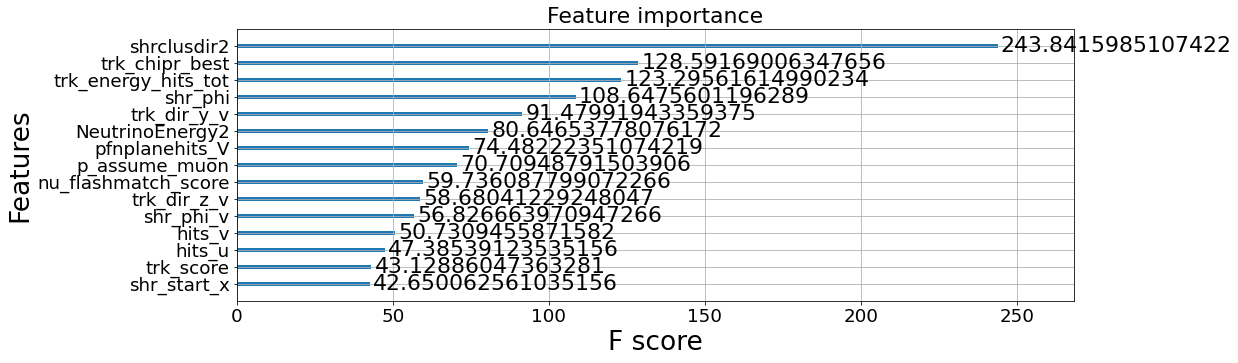

In [7]:
first_model = xgboost.Booster()
first_model.load_model(f'bdts/100_MeV_Adi_variables_test1.json')

plt.figure(figsize=(12,12),facecolor='white')

a = xgboost.plot_importance(first_model,max_num_features=15,importance_type='gain')

print(type(a))  

#Owen's dropdupes from the plotting function
# overlay_post_bdt=data_test_bkg.sort_values('BDT_output',ascending=False).drop_duplicates(subset=["run","evt","sub"])
# dirt_post_bdt=data_test_bkg.sort_values('BDT_output',ascending=False).drop_duplicates(subset=["run","evt","sub"])
# EXT_post_bdt=data_test_bkg.sort_values('BDT_output',ascending=False).drop_duplicates(subset=["run","evt","sub"])
# signal_post_bdt=data_test_bkg.sort_values('BDT_output',ascending=False).drop_duplicates(subset=["run","evt","sub"])

In [14]:
first_model.get_score(importance_type='gain')

{'DeltaMed': 7.233817100524902,
 'shr_pca_2': 5.604423999786377,
 'merge_vtx_x': 7.213500022888184,
 'shr_dedx_v_v': 6.827844619750977,
 'shr_dedx_u_v': 10.862060546875,
 'topological_score': 7.58634090423584,
 'pfnplanehits_V': 74.48222351074219,
 'merge_vtx_y': 8.995959281921387,
 'pt_assume_muon': 15.193015098571777,
 'shrclusfrac1': 7.2423014640808105,
 'CosmicDirAll3D': 7.067112922668457,
 'DeltaMed1h': 14.381204605102539,
 'p': 9.990601539611816,
 'shrMCSMom': 13.560907363891602,
 'dtrk': 22.83882713317871,
 'shr_phi_v': 56.826663970947266,
 'DeltaMed2h': 12.10057258605957,
 'shr_energy_tot': 17.02912712097168,
 'extra_energy_y': 7.564168453216553,
 'merge_bestdist': 15.013615608215332,
 'secondshower_Y_vtxdist': 17.978818893432617,
 'merge_bestdot': 8.319069862365723,
 'shr_score': 9.313923835754395,
 'n_tracks_contained': 23.7565860748291,
 'hits_v': 50.7309455871582,
 'shrclusdir0': 28.65188980102539,
 'pfnplanehits_Y': 5.99220085144043,
 'CosmicIPAll2DEnds': 9.31662368774414,

In [ ]:
#Plotting unweighted

for HNL_mass in HNL_masses:
    
    numdecays_signal = len(signal_samples_dict[HNL_mass])
    #numdecays_bkg = len(Presel_overlay)
    numdecays_bkg = len(Cleaned_Presel_overlay_highest_E)
    plt.figure(figsize=(12,8),facecolor='white')
    SF_sig = numdecays_signal/len(signal_test_dict[HNL_mass][f'BDT_output'])
    SF_overlay = (numdecays_bkg)/len(data_test_bkg[f'BDT_output_{HNL_mass}MeV'])
    print(len(signal_test_dict[HNL_mass][f'BDT_output'])*SF_sig)
    print(len(data_test_bkg[f'BDT_output_{HNL_mass}MeV'])*SF_overlay)

    plt.hist(data_test_bkg[f'BDT_output_{HNL_mass}MeV'],bins=20,range = [0.0,1.0], color='blue', label='Neutrino bkg', alpha=0.8)
    plt.hist(signal_test_dict[HNL_mass][f'BDT_output'],bins=20,range = [0.0,1.0], color='red', label=f'HNL {HNL_mass} MeV', alpha=0.8)
    plt.hist(Cleaned_Presel_dirt_highest_E[f'BDT_output_{HNL_mass}MeV'],bins=20,range = [0.0,1.0], color='orange', label='Dirt bkg', alpha=0.8)
    plt.hist(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV'],bins=20,range = [0.0,1.0], color='green', label=f'EXT bkg', alpha=0.8)

    plt.xlabel('BDT score', fontsize=30)
    plt.ylabel('Entries', fontsize=30)
    plt.rcParams.update({'font.size': 30})
    plt.legend()
    plt.yscale("log")
    plt.show()


In [ ]:
#Need to loop over  HNL_mass points and save new dataframes only keeping highest BDT rows for each 

print("Number of entries in the overlay: " + str(len(data_test_bkg)))
print("Number of entries in the dirt: " + str(len(Cleaned_Presel_dirt)))
print("Number of entries in the EXT: " + str(len(Cleaned_Presel_EXT)))

overlay_post_bdt_dict = {}
dirt_post_bdt_dict = {}
EXT_post_bdt_dict = {}
signal_post_bdt_dict = {}

for HNL_mass in HNL_masses:
    print(f"Number of entries in the {HNL_mass}MeV signal: " + str(len(signal_test_dict[HNL_mass])))

    data_test_bkg[f"highest_bdt_score_{HNL_mass}"]=data_test_bkg[f'BDT_output_{HNL_mass}MeV'].groupby("entry").transform(max) == data_test_bkg[f'BDT_output_{HNL_mass}MeV']
    Cleaned_Presel_dirt[f"highest_bdt_score_{HNL_mass}"]=Cleaned_Presel_dirt[f'BDT_output_{HNL_mass}MeV'].groupby("entry").transform(max) == Cleaned_Presel_dirt[f'BDT_output_{HNL_mass}MeV']
    Cleaned_Presel_EXT[f"highest_bdt_score_{HNL_mass}"]=Cleaned_Presel_EXT[f'BDT_output_{HNL_mass}MeV'].groupby("entry").transform(max) == Cleaned_Presel_EXT[f'BDT_output_{HNL_mass}MeV']
    signal_test_dict[HNL_mass][f"highest_bdt_score"]=signal_test_dict[HNL_mass]['BDT_output'].groupby("entry").transform(max) == signal_test_dict[HNL_mass]['BDT_output']

    overlay_post_bdt_dict[HNL_mass] = data_test_bkg.query(f"highest_bdt_score_{HNL_mass}")
    dirt_post_bdt_dict[HNL_mass] = Cleaned_Presel_dirt.query(f"highest_bdt_score_{HNL_mass}")
    EXT_post_bdt_dict[HNL_mass] = Cleaned_Presel_EXT.query(f"highest_bdt_score_{HNL_mass}")
    signal_post_bdt_dict[HNL_mass] = signal_test_dict[HNL_mass].query("highest_bdt_score")

print()
print("-----Post dropping entries-----")
print("Number of entries in the overlay: " + str(len(overlay_post_bdt_dict[200])))
print("Number of entries in the dirt: " + str(len(dirt_post_bdt_dict[200])))
print("Number of entries in the EXT: " + str(len(EXT_post_bdt_dict[200])))
print("Number of entries in the signal: " + str(len(signal_post_bdt_dict[200])))

##  Testing variables

In [ ]:
#FLAT_Presel_overlay = Presel_overlay.columns.to_flat_index()
#FLAT_Presel_overlay = Presel_overlay.reset_index()
#FLAT_Presel_overlay = Presel_overlay(feature_names, flatten=False)

for var in Presel_overlay.keys():
    #if type(Presel_overlay.keys()[i]) == "numpy.ndarray":
    if isinstance(Presel_overlay[var][0],np.ndarray):
        if type(Presel_overlay[var][0]) == np.ndarray:
            print(var)
            

In [ ]:
feature_names = Variables.First_pass_vars

value = -1e15
new_value = -9999

for var in feature_names:
    print(str(var)+' '+str(Presel_overlay[var][16]))
    
print()

# for var in feature_names:
#     print(str(var)+' '+str(FLAT_Presel_overlay[var][16]))

if type(Presel_overlay['shr_dedx_v_v'][0])==np.ndarray:
    print("yes it is")
    for i in (Presel_overlay['shr_dedx_v_v']):
        Num = Presel_overlay['shr_dedx_v_v'][i].size
        if Num == 1:
            Presel_overlay['shr_dedx_v_v'][i][0] = new_value
        else:
            for j in range(Num):
                if (Presel_overlay['shr_dedx_v_v'][i][j] < value):
                    Presel_overlay['shr_dedx_v_v'][i][j] = new_value
        
else:
    print("no it isnt")
